In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
!pip install scipy
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
import random

file1 = 'athletes.csv'
file2 = 'countries.csv'

athletes=pd.read_csv(file1)
countries = pd.read_csv(file2)
countries.rename(columns = {'code':'nationality'}, inplace = True)

full_athlete_df = pd.merge(athletes,countries,how='inner',on ='nationality')
full_athlete_df['sex'] = full_athlete_df.sex.map(dict(female=1, male=0))

full_athlete_df['Won_a_medal'] = full_athlete_df['gold'] + full_athlete_df['silver'] + full_athlete_df['bronze']
full_athlete_df['Won_a_medal'].values[full_athlete_df['Won_a_medal'].values > 0] = 1
full_athlete_df['dob'] = pd.to_datetime(full_athlete_df.dob)
full_athlete_df['dob'] = full_athlete_df['dob'].mask(full_athlete_df['dob'].dt.year > 2016,
                                               full_athlete_df['dob'] - pd.DateOffset(years=100))
full_athlete_df=full_athlete_df.drop(['gold', 'silver','bronze','id','name','nationality'], axis=1)
full_athlete_df["dob"]= [2014-x.year  for x in full_athlete_df["dob"]]
full_athlete_df.columns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Index(['sex', 'dob', 'height', 'weight', 'sport', 'country', 'population',
       'gdp_per_capita', 'Won_a_medal'],
      dtype='object')

In [2]:
full_athlete_df= full_athlete_df.dropna()
df=full_athlete_df.sample(n=200)

**Part 1**

In [3]:
# Q1.1 CI FOR BETA ESTIMATORS Based on the covarieance matrix


x_df = df[['dob','sex','height']]
y_df = df[['weight']]
y_matrix = y_df.to_numpy()
x_matrix = x_df.to_numpy()
x_matrix = np.c_[np.ones(x_matrix.shape[0]), x_matrix]
n = x_matrix.shape[0]
p = x_matrix.shape[1]

b_vec = np.matmul(x_matrix.T,x_matrix)
b_vec = np.linalg.inv(b_vec)
b_vec = np.matmul(b_vec,x_matrix.T)
b_vec = np.matmul(b_vec,y_matrix)


C = np.linalg.inv(x_matrix.T@x_matrix)
e = y_matrix - np.dot(x_matrix, b_vec)
var_beta = 1/(n-p)*sum([x**2 for x in e])
full_athlete_df



full_x_df = full_athlete_df[['dob','sex','height']]
full_y_df = full_athlete_df[['weight']]
full_y_matrix = full_y_df.to_numpy()
full_x_matrix = full_x_df.to_numpy()
full_x_matrix = np.c_[np.ones(full_x_matrix.shape[0]), full_x_matrix]


full_b_vec = np.matmul(full_x_matrix.T,full_x_matrix)
full_b_vec = np.linalg.inv(full_b_vec)
full_b_vec = np.matmul(full_b_vec,full_x_matrix.T)
full_b_vec = np.matmul(full_b_vec,full_y_matrix)

len_cov = []
z = norm.ppf(0.975) # normal statistic of  desired interval size
for i in range(len(b_vec)):
  an =  b_vec[i]-z*np.sqrt(var_beta)
  bn =  b_vec[i]+ z*np.sqrt(var_beta)
  len_cov.append(bn-an)
  print(f"95% Confidence Interval For beta_{i} estimator is: ({an},{bn}). \n\t\t\t\t\t\t\tis beta_{i} estimator for whole-dataset in CI? {an<=full_b_vec[i]<=bn}\n")

95% Confidence Interval For beta_0 estimator is: ([-141.99703752],[-101.46055277]). 
							is beta_0 estimator for whole-dataset in CI? [False]

95% Confidence Interval For beta_1 estimator is: ([-20.06068948],[20.47579527]). 
							is beta_1 estimator for whole-dataset in CI? [ True]

95% Confidence Interval For beta_2 estimator is: ([-24.75063152],[15.78585322]). 
							is beta_2 estimator for whole-dataset in CI? [ True]

95% Confidence Interval For beta_3 estimator is: ([87.84307018],[128.37955493]). 
							is beta_3 estimator for whole-dataset in CI? [ True]



In [4]:
#Q1.1.2
B=400
alpha=0.05
z = norm.ppf(1-alpha/2)
x0 = []
dob = []
sex= []
height =[]
for i in range(B):
  bootstrap = df.sample(n=200,replace=True)
  y= bootstrap["Won_a_medal"].values
  X=bootstrap
  x_df = bootstrap[['dob','sex','height']]
  y_df = bootstrap[['weight']]
  y_matrix = y_df.to_numpy()
  x_matrix = x_df.to_numpy()
  x_matrix = np.c_[np.ones(x_matrix.shape[0]), x_matrix]
  n = x_matrix.shape[0]
  p = x_matrix.shape[1]

  b_vec = np.matmul(x_matrix.T,x_matrix)
  b_vec = np.linalg.inv(b_vec)
  b_vec = np.matmul(b_vec,x_matrix.T)
  b_vec = np.matmul(b_vec,y_matrix)
  x0.append(b_vec[0][0])
  dob.append(b_vec[1][0])
  sex.append(b_vec[2][0])
  height.append(b_vec[3][0])

Normal_ci_list=[]
betas = ['b0','b1 - age','b2 - sex','b3 - height']
for i , b in enumerate([x0,dob,sex,height]):
  b = np.array(b)
  se_b = np.mean(b**2)  - (np.mean(b))**2
  an = b_vec[i][0]-z*se_b
  bn = b_vec[i][0]+z*se_b
  print(f'Bootstrap CI: Normal Approximation For {betas[i]} Is:{(an,bn)}')
  Normal_ci_list.append(bn-an)

Bootstrap CI: Normal Approximation For b0 Is:(-481.1838763785594, 260.1407782070713)
Bootstrap CI: Normal Approximation For b1 - age Is:(-0.1543097597079191, -0.09413251631818272)
Bootstrap CI: Normal Approximation For b2 - sex Is:(-12.381376128648226, -2.9153025876033265)
Bootstrap CI: Normal Approximation For b3 - height Is:(2.504405314203609, 212.63599043211627)


In [5]:
#Q1.1.3
Pivotal_ci_list=[]
for i , b in enumerate([x0,dob,sex,height]):
  b = np.array(sorted(b))
  an = 2*b_vec[i][0]-b[int(400*(1-alpha/2))-1]
  bn = 2*b_vec[i][0]-b[int(1000*(alpha/2))-1]
  print(f'Bootstrap CI: Pivotal Interval  For {betas[i]} Is:{an,bn}')
  Pivotal_ci_list.append(bn-an)


Bootstrap CI: Pivotal Interval  For b0 Is:(-126.04879082140312, -75.73008254816679)
Bootstrap CI: Pivotal Interval  For b1 - age Is:(-0.699214067494554, -0.27097672964798336)
Bootstrap CI: Pivotal Interval  For b2 - sex Is:(-13.813050035097472, -8.326858068616627)
Bootstrap CI: Pivotal Interval  For b3 - height Is:(91.00344777100577, 117.86067494360698)


In [6]:
#Q1.1.4

Percentile_ci_list=[]
for i , b in enumerate([x0,dob,sex,height]):
  b = np.array(sorted(b))
  bn = b[int(400*(1-alpha/2))-1]
  an = b[int(1000*(alpha/2))-1]
  print(f'Bootstrap CI: Percentile Interval For {betas[i]} Is:{an, bn}')
  Percentile_ci_list.append(bn-an)


Bootstrap CI: Percentile Interval For b0 Is:(-145.31301562332126, -94.99430735008494)
Bootstrap CI: Percentile Interval For b1 - age Is:(0.022534453621881556, 0.45077179146845214)
Bootstrap CI: Percentile Interval For b2 - sex Is:(-6.969820647634926, -1.4836286811540802)
Bootstrap CI: Percentile Interval For b3 - height Is:(97.2797208027129, 124.13694797531411)


In [7]:
#Q2

compare_df = pd.DataFrame({
    "CI len Based on the covarieance matrix": len_cov ,'Bootstrap CI: Normal Approximation len': Normal_ci_list, 'Bootstrap CI: Pivotal Interval len':Pivotal_ci_list,'Bootstrap CI: Percentile Interval len': Percentile_ci_list
    # "b1": [mallow_value, mallow_value_in]
})
compare_df.index = ["b0","b1 - age","b2 -sex ","b3 - height "]
compare_df

,CI len Based on the covarieance matrix,Bootstrap CI: Normal Approximation len,Bootstrap CI: Pivotal Interval len,Bootstrap CI: Percentile Interval len
b0,[40.53648474651713],741.324655,50.318708,50.318708
b1 - age,[40.53648474651714],0.060177,0.428237,0.428237
b2 -sex,[40.53648474651714],9.466074,5.486192,5.486192
b3 - height,[40.53648474651715],210.131585,26.857227,26.857227


In [8]:
#Q2
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from scipy.stats import norm

y= full_athlete_df["Won_a_medal"].values
X= full_athlete_df

x_df = full_athlete_df[['dob','sex','height']]
y_df = full_athlete_df[['weight']]
y_matrix = y_df.to_numpy()
x_matrix = x_df.to_numpy()
x_matrix = np.c_[np.ones(x_matrix.shape[0]), x_matrix]
n = x_matrix.shape[0]
p = x_matrix.shape[1]

b_vec = np.matmul(x_matrix.T,x_matrix)
b_vec = np.linalg.inv(b_vec)
b_vec = np.matmul(b_vec,x_matrix.T)
b_vec = np.matmul(b_vec,y_matrix)
print("The model is:")
print("y = %5.10f + %5.10f*x1 + %5.10f*x2 + %5.10f*x3" % (b_vec[0][0],b_vec[1][0],
     b_vec[2][0],b_vec[3][0]))
print("Beta vector is:" ,b_vec )
print("Where: ")
for i,x in enumerate(['age','gender','height']):
  print(f"x{i+1} = {x}")

The model is:
y = -96.5220228192 + 0.1335907235*x1 + -5.5487339465*x2 + 94.9363565117*x3
Beta vector is: [[-96.52202282]
 [  0.13359072]
 [ -5.54873395]
 [ 94.93635651]]
Where: 
x1 = age
x2 = gender
x3 = height


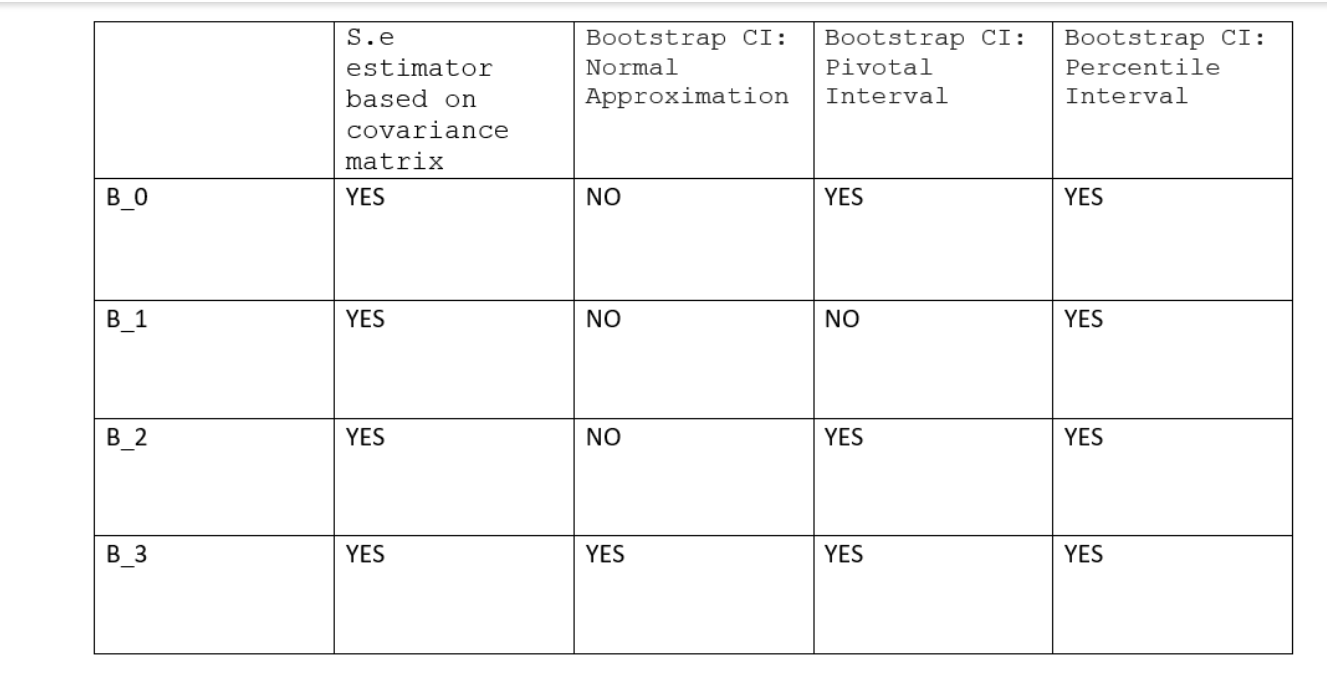

In [11]:
#3.1

athletes_100 = pd.concat([ full_athlete_df, df]).drop_duplicates(keep=False)

athletes_100 = athletes_100.sample(n=100)




In [13]:


from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from scipy.stats import norm

y= athletes_100["Won_a_medal"].values
X=athletes_100

x_df = athletes_100[['dob','sex','height']]
y_df = athletes_100[['weight']]
y_matrix_100 = y_df.to_numpy()
x_100 = x_df.to_numpy()
x_100 = np.c_[np.ones(x_100.shape[0]), x_100]
n = x_100.shape[0]
p = x_100.shape[1]

b_vec = np.matmul(x_100.T,x_100)
b_vec = np.linalg.inv(b_vec)
b_vec = np.matmul(b_vec,x_100.T)
b_vec = np.matmul(b_vec,y_matrix_100)

y_pred =  np.matmul(x_100,b_vec)
print("The 100 predections are :",y_pred)


The 100 predections are : [[ 59.72476698]
 [ 94.8886038 ]
 [ 70.60682639]
 [ 77.58731764]
 [ 75.57817527]
 [ 87.51437278]
 [ 63.75869435]
 [ 81.62124502]
 [ 78.26335861]
 [ 50.90071796]
 [ 66.21044451]
 [ 61.42032288]
 [ 87.33314553]
 [ 86.78946379]
 [ 76.66553876]
 [ 79.56323462]
 [ 58.19673581]
 [ 96.15719455]
 [ 99.82866742]
 [ 92.83253353]
 [ 77.60296028]
 [ 54.39096359]
 [ 79.24964815]
 [ 56.0532941 ]
 [ 74.83762364]
 [ 76.30308427]
 [ 51.08194521]
 [ 62.523329  ]
 [ 62.27759109]
 [ 69.10814037]
 [ 79.23400552]
 [ 79.01955287]
 [ 83.26793289]
 [105.70615255]
 [ 98.54443405]
 [ 75.90740438]
 [ 71.87541713]
 [ 87.51437278]
 [ 46.65427807]
 [ 86.80510642]
 [ 75.03449353]
 [ 59.56112249]
 [ 82.57430916]
 [ 82.19621203]
 [ 84.58345153]
 [ 67.83954963]
 [ 81.60560238]
 [109.03081357]
 [ 86.21449677]
 [ 92.65130628]
 [ 68.59768402]
 [ 75.20007814]
 [ 64.31801873]
 [ 68.91127049]
 [ 86.06455479]
 [102.23154956]
 [ 86.24578204]
 [ 73.91584477]
 [ 69.85063212]
 [ 93.21063066]
 [ 83.85854254

In [14]:
#Q3.2 - Bootstrap CI: Normal Approximation
pred_mat = []

for i in range(B):
  bootstrap = athletes_100.sample(n=100,replace=True)
  y= bootstrap["Won_a_medal"].values
  X=bootstrap
  x_df = bootstrap[['dob','sex','height']]
  y_df = bootstrap[['weight']]
  y_matrix = y_df.to_numpy()
  x_matrix = x_df.to_numpy()
  x_matrix = np.c_[np.ones(x_matrix.shape[0]), x_matrix]
  n = x_matrix.shape[0]
  p = x_matrix.shape[1]
  b_vec = np.matmul(x_matrix.T,x_matrix)
  b_vec = np.linalg.inv(b_vec)
  b_vec = np.matmul(b_vec,x_matrix.T)
  b_vec = np.matmul(b_vec,y_matrix) 
  pred = np.matmul(x_100, b_vec)
  pred_mat.append(pred)

pred_mat = np.array(pred_mat)
pred_matrix = np.float64(pred_mat)
se_hat = np.std(pred_matrix, axis=0)

count =1
prob =0
for i , se, j in zip(y_pred,se_hat,y_matrix_100):
    an = i[0] - z*se[0]
    bn = i[0] + z * se[0]
    if j >= an and j<= bn:
      prob +=1
    print(f'Bootstrap CI: Normal Approximation For y{count} Is:{an, bn}')
    count +=1


Bootstrap CI: Normal Approximation For y1 Is:(57.70349693517199, 61.74603701569969)
Bootstrap CI: Normal Approximation For y2 Is:(88.97033993364941, 100.80686767523493)
Bootstrap CI: Normal Approximation For y3 Is:(67.72868511942478, 73.48496765128111)
Bootstrap CI: Normal Approximation For y4 Is:(75.14678163635156, 80.02785364820974)
Bootstrap CI: Normal Approximation For y5 Is:(72.39265724775426, 78.7636932964716)
Bootstrap CI: Normal Approximation For y6 Is:(84.35061820867473, 90.67812735436708)
Bootstrap CI: Normal Approximation For y7 Is:(61.48673494234167, 66.03065375776028)
Bootstrap CI: Normal Approximation For y8 Is:(79.07822439834077, 84.1642656354508)
Bootstrap CI: Normal Approximation For y9 Is:(73.8983024784507, 82.6284147416646)
Bootstrap CI: Normal Approximation For y10 Is:(47.94298008450746, 53.85845584104826)
Bootstrap CI: Normal Approximation For y11 Is:(62.1235423808146, 70.29734664579266)
Bootstrap CI: Normal Approximation For y12 Is:(57.378451943663045, 65.46219380

In [15]:
#q3.3
print("The precent of CI intervals which contain the real Y is: %" ,prob)

The precent of CI intervals which contain the real Y is: % 35


As we can see the precent isn't close to 95%
That is because we calculate CI for the expectation, without including the noise.

**Q3.4**

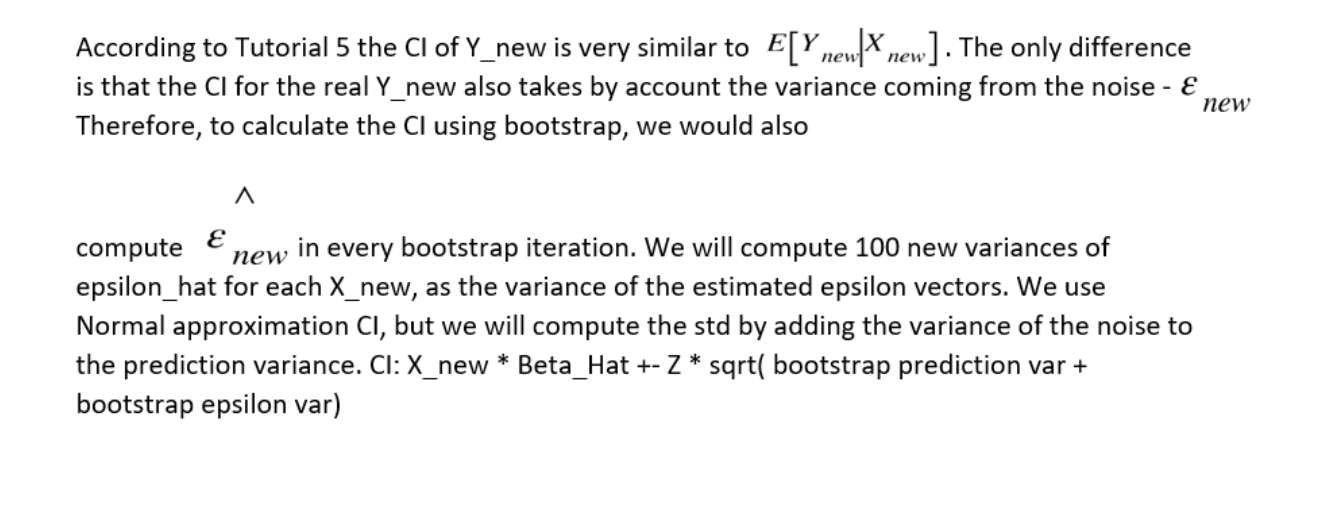

**Part 2**

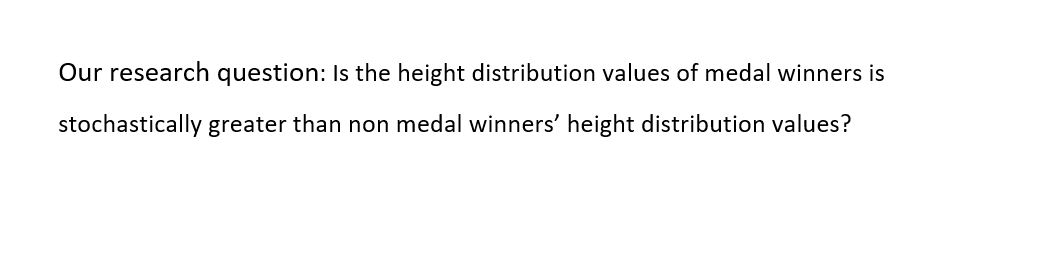

In [ ]:
#Q2:

np.random.seed(42)
full_athlete_df= full_athlete_df.dropna()
df=full_athlete_df.sample(n=200)

In [ ]:
#Q3.1:
df_won = df[df['Won_a_medal']==1]
mu1 =  df_won['height'].mean()
df_lost = df[df['Won_a_medal']==0]
mu2 =  df_lost['height'].mean()
delta_hat = abs(mu1-mu2)
print(f'Estimator for expectaion for athletes who won a medal is: {mu1}')
print(f'Estimator for expectaion for athletes who didnt win a medal is: {mu2}')
print(f'Estimator for expectaion for delta is: {delta_hat}')

Estimator for expectaion for athletes who won a medal is: 1.754375
Estimator for expectaion for athletes who didnt win a medal is: 1.7693452380952381
Estimator for expectaion for delta is: 0.01497023809523812


We have explored the distribution of the expectations in project 2. we have shown before that both groups posses height values that behave approximately Normal.
Delta is a linear combinaition of mu1 and mu2 and since we assume they are of normal distribution, we get that delta is also normal. The MLE for mu1, mu2, are the means. 

Therefore we can assume that delta, estimated by (mean_of_winners - mean_of_losers), is  an MLE for Delta. 

In [ ]:
#Q3.2
alpha=0.05
z = norm.ppf(1-alpha/2)

var_winners = np.var(df_won['height']) / len(df_won['height'])
var_losers = np.var(df_lost['height']) / len(df_lost)
se_hat_heights = np.sqrt(var_winners + var_losers)
an=delta_hat - z * se_hat_heights
bn= delta_hat + z * se_hat_heights
print(f'Confidence interval for delta is : {(an,bn)}')

Confidence interval for delta is : (-0.03085313529444414, 0.06079361148492038)


In [ ]:
#Q3.3
df_all_won = full_athlete_df[full_athlete_df['Won_a_medal']==1]
mu1 =  df_all_won['height'].mean()
df_all_lost = full_athlete_df[full_athlete_df['Won_a_medal']==0]
mu2 =  df_all_lost['height'].mean()
delta_hat_all= abs(mu1-mu2)
print(f'Delta estmator for whole dataset: {delta_hat}')

print(f'Is delta in Confidence interval for 200 samples delta : {(an<delta_hat_all<bn)}')



Delta estmator for whole dataset: 0.01497023809523812
Is delta in Confidence interval for 200 samples delta : True


In [ ]:
#Q3.4 Wald test:
print("Wald test:\n")

import numpy as np
import scipy.stats as stats
import math as m
won = df_won['height'].values
n_won= len(won)
lost = df_lost['height'].values
n_lost = len(lost)
Wald_statistic = (won.mean() - lost.mean())/m.sqrt(won.var(ddof=0)/n_won + lost.var(ddof=0)/n_lost)
P_value = 2*stats.norm.cdf(-abs(Wald_statistic))
Wald_test_quantile = stats.t.ppf(0.975, n_won+n_lost-2)

print("Wald statistic: ",(Wald_statistic))
print("P value for Wald test: ",(P_value))
print("W test quantile: ",(Wald_test_quantile))

if Wald_statistic > Wald_test_quantile or Wald_statistic < -Wald_test_quantile:
 print('\nIn Reject H0 Region')
else:
 print('\nNot in Reject H0 Region')
 print("We could not prove with Wald test that medal winners\
  height distribution  is not stochastically greater of those who didnt win a medal")
import scipy.misc as misc
B=400
print("\nPermutations test:\n")

counter = 0
for b in range(B):
  df_won = df.sample(n_won)
  df_all = df.merge(df_won, how='left', indicator=True)
  not_in_sampled = df_all[df_all["_merge"] == "left_only"]
  df_lost = not_in_sampled.drop("_merge", axis=1)
  mu1_hat_temp = np.mean(df_won['height'])
  mu2_hat_temp = np.mean(df_lost['height'])
  delta_temp = mu1_hat_temp - mu2_hat_temp
  if delta_hat <= delta_temp:
    counter += 1

test_statistic = counter / B

print("P value for Permutations test: ",(alpha))
print("test statistic: ",(test_statistic))

if test_statistic <= alpha:
  print('\nIn Reject H0 Region')

  print("Reject H0. We have found with permutation test that medal winners height \
        distribution  is  stochastically greater of those who didnt win a medal")
else:
  print('\nNot in Reject H0 Region')
  print("Do not reject H0. We could not prove with a permutation test that medal winners\
  height distribution  is not stochastically greater of those who didnt win a medal")

Wald test:

Wald statistic:  -0.6403091989133816
P value for Wald test:  0.5219716014793767
W test quantile:  1.9720174778338955

Not in Reject H0 Region
We could not prove with Wald test that medal winners  height distribution  is not stochastically greater of those who didnt win a medal

Permutations test:

P value for Permutations test:  0.05
test statistic:  0.29

Not in Reject H0 Region
Do not reject H0. We could not prove with a permutation test that medal winners  height distribution  is not stochastically greater of those who didnt win a medal


In [ ]:
#Q2.4.1
df_won = df[df['Won_a_medal']==1]
m1 =  df_won['height'].median()
df_lost = df[df['Won_a_medal']==0]
m2 =  df_lost['height'].median()
delta_hat = abs(m1-m2)
won = df_won['height'].values
n_won= len(won)
lost = df_lost['height'].values
n_lost = len(lost)
print(f'Median for winners: {m1} median for losers: {m2} delta_hat: {delta_hat}')

Median for winners: 1.73 median for losers: 1.76 delta_hat: 0.030000000000000027


Height is known to be distributed Normally. moreover, we have shown in part 2 of the project that is height of the athletes that appear on the database is behaving approximately normal.
The difference of medians is MLE.

since the MLE is a function of the entire empirical sample, and the median is not based **not** the empirical sample.


In [ ]:
#Q2.4.2
var_winners = np.var(df_won['height']) / len(df_won['height'])
var_losers = np.var(df_lost['height']) / len(df_lost)
se_hat_heights = np.sqrt(var_winners + var_losers)
an=delta_hat - z * se_hat_heights
bn= delta_hat + z * se_hat_heights
print(f'Confidence interval for delta (median) is : {(an,bn)}')

#Q2.4.3
df_all_won = full_athlete_df[full_athlete_df['Won_a_medal']==1]
m1 =  df_all_won['height'].median()
df_all_lost = full_athlete_df[full_athlete_df['Won_a_medal']==0]
m2 =  df_all_lost['height'].median()
delta_hat_all= abs(m1-m2)
print(f'Delta estmator for whole dataset: {delta_hat}')
print(f'Is delta for entire dataset in Confidence interval for 200 samples delta : {(an<delta_hat_all<bn)}')


Confidence interval for delta (median) is : (-0.015823373389682233, 0.07582337338968229)
Delta estmator for whole dataset: 0.030000000000000027
Is delta for entire dataset in Confidence interval for 200 samples delta : True


In [ ]:
#Q2.4.4
print("\nPermutations test:\n")

counter = 0
for b in range(B):
  df_won = df.sample(n_won)
  df_all = df.merge(df_won, how='left', indicator=True)
  not_in_sampled = df_all[df_all["_merge"] == "left_only"]
  df_lost = not_in_sampled.drop("_merge", axis=1)
  mu1_hat_temp = np.median(df_won['height'])
  mu2_hat_temp = np.median(df_lost['height'])
  delta_temp = mu1_hat_temp - mu2_hat_temp
  if delta_hat <= delta_temp:
    counter += 1

test_statistic = counter / B

print("P value for Permutations test: ",(alpha))
print("test statistic: ",(test_statistic))

if test_statistic <= alpha:
  print('\nIn Reject H0 Region')

  print("Reject H0. We have found with permutation test that medal winners height \
        distribution  is  stochastically greater of those who didnt win a medal")
else:
  print('\nNot in Reject H0 Region')
  print("Do not reject H0. We could not prove with a permutation test that medal winners\
 \nheight distribution  is not stochastically greater of those who didnt win a medal")


Permutations test:

P value for Permutations test:  0.05
test statistic:  0.2425

Not in Reject H0 Region
Do not reject H0. We could not prove with a permutation test that medal winners 
height distribution  is not stochastically greater of those who didnt win a medal


Wald test cannot be used. We cannot assume that delta_hat is asymptotic normal since it is a difference of medians and we dont know how they distribute.
---

In order to use T- test, there are 4 requierments:
1. Independence: The observations in each group should be independent of each other.

2. Normality: The underlying population from which the samples are drawn should be approximately normally distributed.

3. Equality of variances: The variances of the two populations should be equal.

4. Sample size should be large enough. It is recommended to have a sample size of at least 30.

As 1,2,4 can be assumed on the data, we dont know that there is equality of variance in the two samples. It is possible to run additional tests and check if this condition exists. Then we can see whether T-test is appliable in our case or not.


We can use normal approximation because the degrees are asymptotic normal and group sizes are large enough.

In [ ]:
#Q4.5:
print("\nNormal approximation:\n")
sample_heights = sorted(full_athlete_df['height'])
# ties_dict = {}
# for w in sample_heights:
#  ties_dict[w] = 0
# for w in sample_heights:
#  ties_dict[w] += 1

def compute_sum_ranks(winner_weights, sample_heights):
  sum_ranks = 0
  for i, x  in enumerate(sample_heights):
    if x in winner_weights:
      if i < len(sample_heights):
        counter=1
        summer=i+1
        while True:
          if sample_heights[i] == sample_heights[i+counter]:
            summer+=(i+counter)
            counter+=1
          else:
              sum_ranks+=(summer/counter)
              break
        else:
          sum_ranks += (i+1)
  return sum_ranks

df_won = df[df['Won_a_medal']==1]["height"]
sum_ranks = compute_sum_ranks(df_won,sample_heights)

N = n_won+n_lost
est_mean = n_won * (N + 1) / 2
sum_ties = 0
est_var = (n_won * n_lost * (N + 1) / 12)
wilcox_statistic = (sum_ranks - est_mean) / np.sqrt(est_var)
Z_q = stats.norm.ppf(0.95)
print("Test statistic: ",wilcox_statistic )
print("z_q: ", Z_q)

if wilcox_statistic > Z_q:
  print('\nIn Reject H0 Region')

  print("Reject H0. We have found with normal approximation that medal winners height \
      \ndistribution  is  stochastically greater of those who didnt win a medal")
else:
  print('\nNot in Reject H0 Region')
  print("Do not reject H0. We could not prove with aapproximation that medal winners height distribution is not stochastically\ngreater of those who didnt win a medal")



Normal approximation:

Test statistic:  -10.71714247629203
z_q:  1.6448536269514722

Not in Reject H0 Region
Do not reject H0. We could not prove with aapproximation that medal winners height distribution is not stochastically
greater of those who didnt win a medal


In [ ]:
print("re-sampling:\n")

counter = 0
for b in range(B):
 #Re distribute medal winners among sample
  boots_winners = full_athlete_df.sample(n_won)

  current_rank = compute_sum_ranks(boots_winners,sample_heights)
  if sum_ranks <= current_rank:
    counter += 1
pval_statistic = counter/B

print("P value for Permutations test: ",(alpha))
print("test statistic: ",(test_statistic))

if test_statistic <= alpha:
  print('\nIn Reject H0 Region')

  print("Reject H0. We have found with permutation test that medal winners height \
        distribution  is  stochastically greater of those who didnt win a medal")
else:
  print('\nNot in Reject H0 Region')
  print("Do not reject H0. We could not prove with a permutation test that medal winners\
 \nheight distribution  is not stochastically greater of those who didnt win a medal")

re-sampling:

P value for Permutations test:  0.05
test statistic:  0.2425

Not in Reject H0 Region
Do not reject H0. We could not prove with a permutation test that medal winners 
height distribution  is not stochastically greater of those who didnt win a medal


We have systematically shown that the height distribution amongst olympic athletes who won medal, is not stochastically greater than height distribution of athletes who didnt win any medal at the olympic athletes Rio De Janeiro 2014 Olympic events. The average height difference is about 2 and we have shown it is statistically neglectable.  We could not deny the null hypothesis in every test , meaning that our assumption was incorrect.